In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
# Graficos
import seaborn as sns
import matplotlib.pyplot as plt

# Preparacion de datos para el modelo y Optimizacion de hipermarametros
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
# Modelos
from sklearn.ensemble import RandomForestClassifier
# Metricas para calificar el modelo
from sklearn.metrics import *





In [2]:
# importamos los datos del proyecto DecisionTreeClassifier
X_train = pd.read_csv('/workspaces/decission_tree/src/xtrain.csv')
X_test = pd.read_csv('/workspaces/decission_tree/src/xtest.csv')
y_train = pd.read_csv('/workspaces/decission_tree/src/ytrain.csv')
y_test = pd.read_csv('/workspaces/decission_tree/src/ytest.csv')

In [3]:
# Instanciamos primer modelo
model = RandomForestClassifier(random_state=42)
# entrenamiento
model.fit(X_train, y_train.squeeze())

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8


Se obtiene una precision del 80% eb el primer modelo sin ninguna optimización

In [4]:
# Procedemos a graficar la variación de la exactitud respecto al parametro n_estimators. Para ello:

# creamos un dataframe vacio
columns = ['estimators', 'accuracy']
metrics_df = pd.DataFrame(columns=columns)
# creamos un rango sobre el que iterarán los valores de n_estimators
range = np.arange(1, 600, 1)
# Mediante este bucle for entrenamos el modelo en todos los valores definidos en range
for i in range:
    model = RandomForestClassifier(random_state=42, n_estimators=i)
    
    model.fit(X_train, y_train.squeeze())

    # Realizamos predicciones con cada valor de range
    y_pred = model.predict(X_test)

    # Calculamos la precisión
    accuracy = accuracy_score(y_test.squeeze(), y_pred)
    # creamos un diccionario que representa una nueva fila que se añadirá al dataframe 
    new_row = {
            'estimators': i,
            'accuracy': accuracy}

    # Añadimos esa fila al DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)
        


/tmp/ipykernel_501/1291838363.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)


In [6]:
# muestra del dataframe resultante
display(metrics_df)

,estimators,accuracy
0,1,0.765517
1,2,0.806897
2,3,0.793103
3,4,0.779310
4,5,0.772414
...,...,...
594,595,0.806897
595,596,0.806897
596,597,0.806897
597,598,0.806897


In [7]:
# Hallamos el indice del dataframe con el mejor resultado 
max_accuracy_index = metrics_df['accuracy'].idxmax()

# Localizamos ese indice  con iloc , mostrando los datos 
max_accuracy_row = metrics_df.loc[max_accuracy_index]

print("Fila con la máxima precisión:")
# imprimimos el resultado para encontrar el mejor valor de estimadores
print(max_accuracy_row)



Fila con la máxima precisión:
estimators          19
accuracy      0.813793
Name: 18, dtype: object


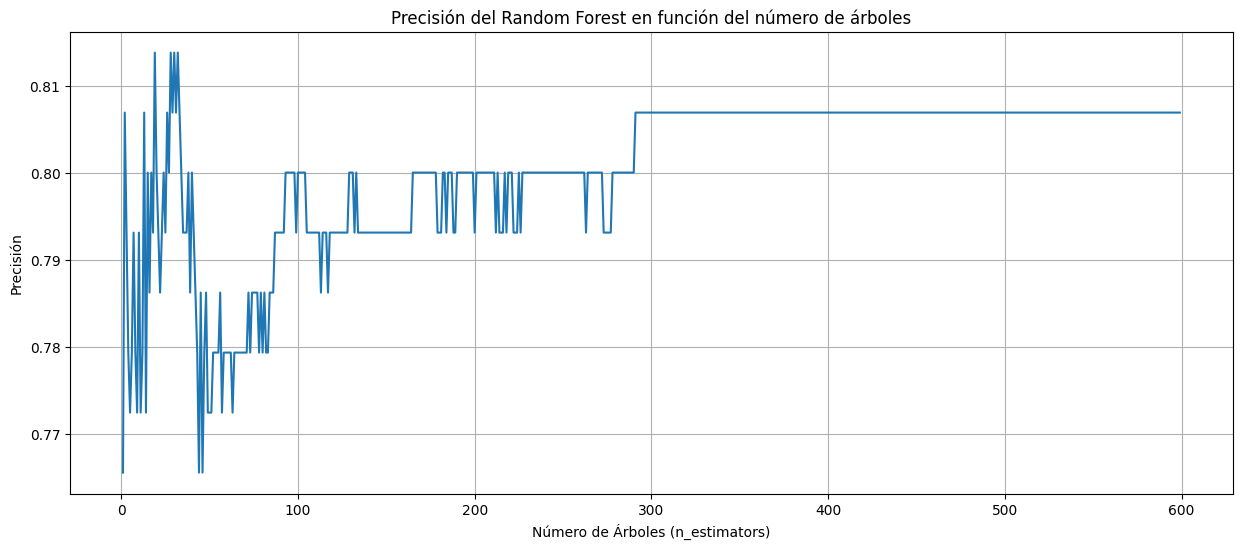

In [11]:
# Extraer scores y parámetros
accuracies = metrics_df['accuracy']  # Asumiendo que 'accuracy' contiene las precisiones
estimators = metrics_df['estimators']  # Asumiendo que 'n_estimators' contiene el número de árboles

# Gráfico de cómo la exactitud varía con n_estimators
plt.figure(figsize=(15, 6))
plt.plot(estimators, accuracies)
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Precisión')
plt.title('Precisión del Random Forest en función del número de árboles')
plt.grid(True)
plt.show()



In [7]:
# Bsandonos en ese numero de estimadores realizamos una busqueda en cuadricula sobre el resto de hiperparametros por si el resultado anterior es  mejorable
model = RandomForestClassifier(n_estimators=30)
# Definimos los rangos de los hiperparametros para la busqueda aleatoria
param_dict = {'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_split': np.arange(2, 50, 2,),
              'min_samples_leaf' : np.arange(1, 50, 2,),
              'max_features': ['sqrt','log2'],
              'max_depth': np.arange(50, 500, 50)}
# Instanciamos  GridSearchCV con el modelo y los hiperparametros definidos en param_dict
grid_search = GridSearchCV(model, param_grid=param_dict,cv=3,n_jobs=-1,scoring='accuracy', verbose=1)
# Ajustamos el modelo
grid_search.fit(X_train, y_train.squeeze())

Fitting 3 folds for each of 32400 candidates, totalling 97200 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=30), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])},
             scoring='accuracy', verbose=1)

Por algun motivo la busqueda de hiperparametros disminuye la precision final del modelo. Requires further investigation.

In [9]:
# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(random_search.best_score_)

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 6}
Mejor puntuación (RMSE) en el conjunto de prueba:
0.7789291882556131
